Attempting to open: /Users/ikikafalioglan/Desktop/hamdi/StreamingHistory_music_1.json
Attempting to open: /Users/ikikafalioglan/Desktop/hamdi/StreamingHistory_music_0.json
Attempting to open: /Users/ikikafalioglan/Desktop/hamdi/StreamingHistory_music_2.json


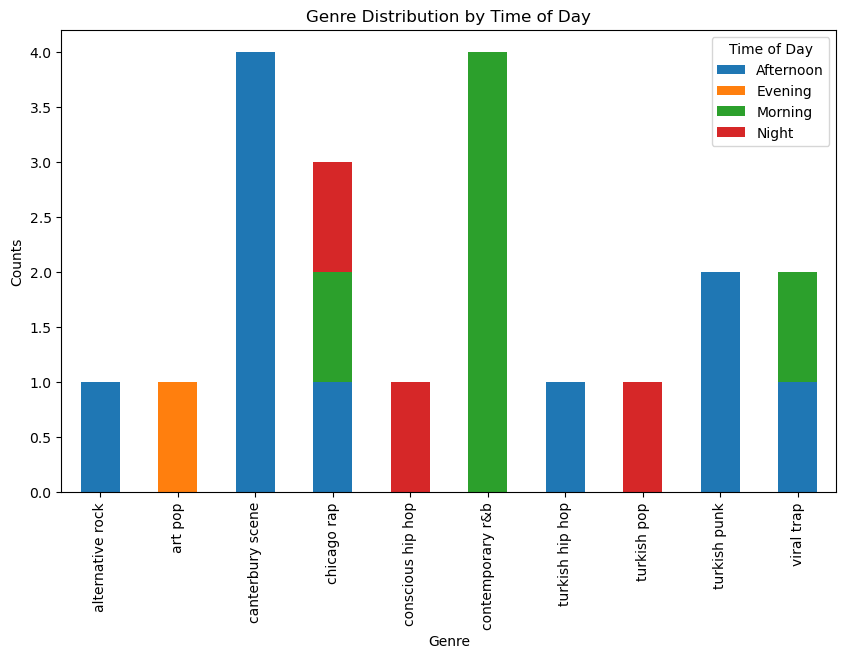

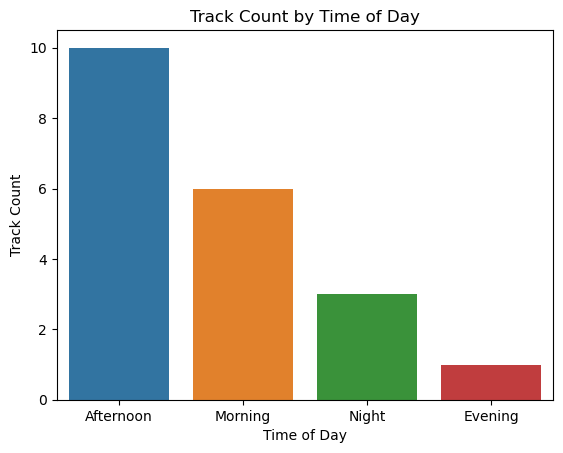

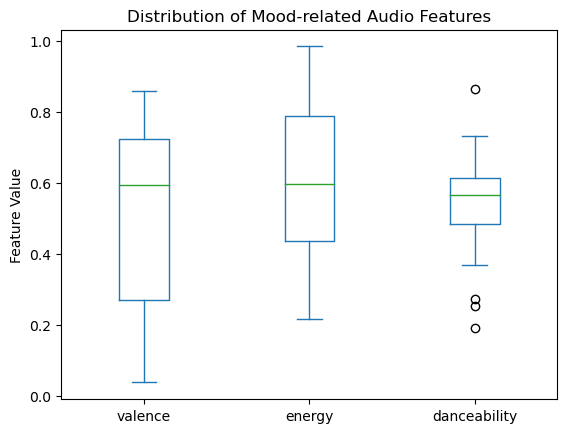

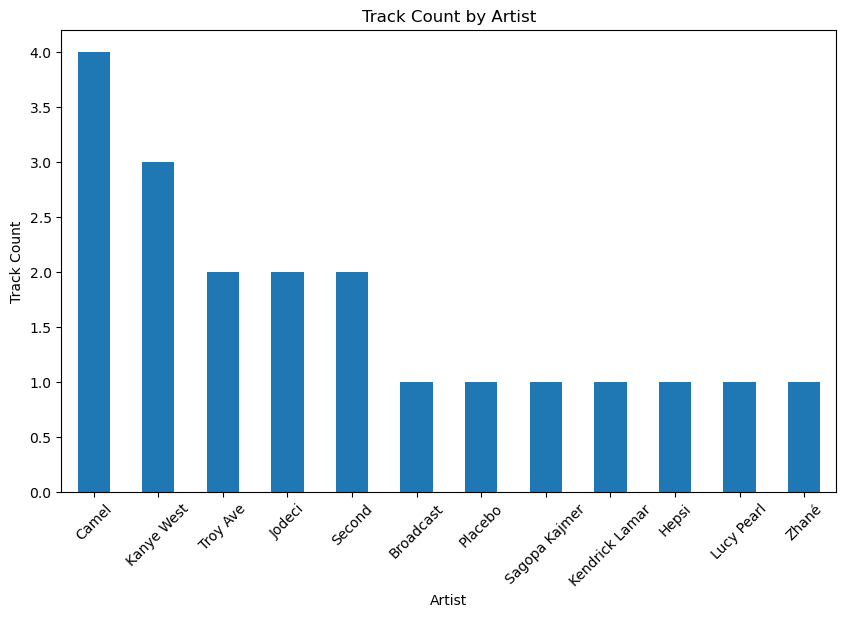

Unique genres in the all-time tracks: 10


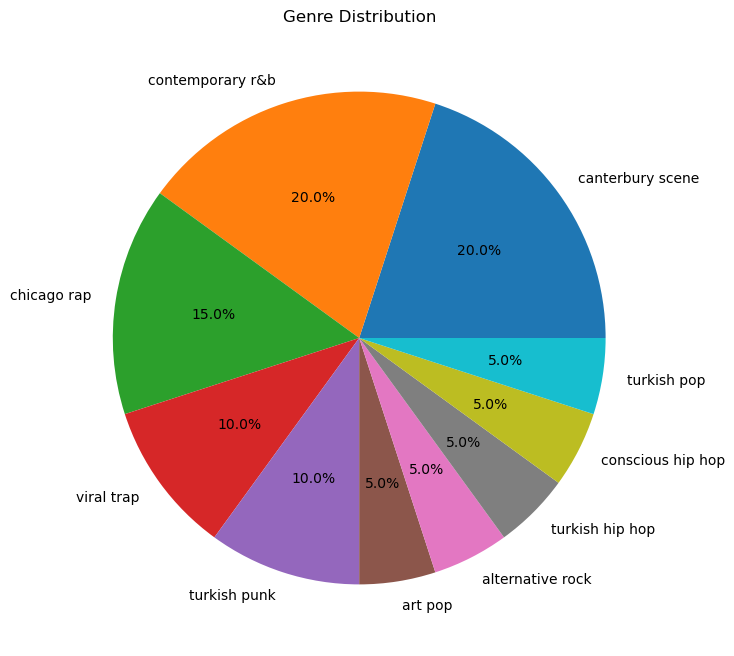

Winter: <a href="https://open.spotify.com/playlist/0b2sy8BHzdAQPkGxWSWvyB" target="_blank">https://open.spotify.com/playlist/0b2sy8BHzdAQPkGxWSWvyB</a>
Spring: <a href="https://open.spotify.com/playlist/77SRYJNHIF7j1kvP9Wm199" target="_blank">https://open.spotify.com/playlist/77SRYJNHIF7j1kvP9Wm199</a>
Summer: <a href="https://open.spotify.com/playlist/6kNAO7fAPRLVLIad5EW5ju" target="_blank">https://open.spotify.com/playlist/6kNAO7fAPRLVLIad5EW5ju</a>
Fall: <a href="https://open.spotify.com/playlist/0EReGyDp6JyQnZtdTMiRv7" target="_blank">https://open.spotify.com/playlist/0EReGyDp6JyQnZtdTMiRv7</a>


In [56]:
import spotipy
import os
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import collections

# Get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__))

# Use os.listdir to get a list of all JSON files in the same directory
json_files = [file for file in os.listdir(current_directory) if file.endswith('.json')]


# Initialize an empty list to store track details
track_details = []

# Loop through each JSON file
for json_file in json_files:
    # Construct the full path to the JSON file
    json_file_path = os.path.join(current_directory, json_file)
    print(f"Attempting to open: {json_file_path}")  # Add this line for debugging
    with open(json_file_path, 'r', encoding='utf-8') as file:
        streaming_history = json.load(file)
    # Assuming the structure of your JSON files is similar to Spotify's API response
    for item in streaming_history:
        track_details.append({
            'track_name': item['trackName'],
            'artist': item['artistName'],
            'added_at': pd.to_datetime(item['endTime']),  # Change to endTime or the appropriate field
        })

# Create a DataFrame from the collected track details
track_df = pd.DataFrame(track_details)

# Set your client ID, client secret, and redirect URI
client_id = 'aecdd128a245422f850ae26efa41f24a'
client_secret = 'b12958865c49467381506e807c3ff7b9'
redirect_uri = 'http://localhost:8081/callback/'
cache_path = os.path.join(os.getcwd(), 'spotify_token_cache.txt')

# Scope to define what access you need (adjust accordingly)
scope = 'user-library-read user-top-read user-read-recently-played playlist-modify-public playlist-modify-private'

# Authentication
auth_manager = SpotifyOAuth(client_id=client_id,
                            client_secret=client_secret,
                            redirect_uri=redirect_uri,
                            scope=scope,
                            cache_path=cache_path)

sp = spotipy.Spotify(auth_manager=auth_manager)



# Fetch all-time listening history
all_time_tracks = sp.current_user_saved_tracks()

track_details = []

for item in all_time_tracks['items']:
    track = item['track']
    artist_id = track['artists'][0]['id']

    # Fetch the artist's genre
    artist = sp.artist(artist_id)
    genre = artist['genres'][0] if artist['genres'] else 'Unknown'

    track_details.append({
        'track_name': track['name'],
        'artist': track['artists'][0]['name'],
        'genre': genre,
        'added_at': pd.to_datetime(item['added_at']),
        'hour_of_day': pd.to_datetime(item['added_at']).hour
    })

track_df = pd.DataFrame(track_details)

def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'
    
def get_season(genre):
    
    if 'hip hop' in genre.lower():
        return 'winter'
    elif 'pop' in genre.lower():
        return 'spring'
    elif 'rock' in genre.lower():
        return 'summer'
    else:
        return 'fall'

track_df['season'] = track_df['genre'].apply(get_season)

track_df['time_of_day'] = track_df['hour_of_day'].apply(get_time_of_day)

# Group by time of day and genre
genre_time_df = track_df.groupby(['time_of_day', 'genre']).size().reset_index(name='counts')

# Pivot the data for better visualization
pivot_df = genre_time_df.pivot(index='genre', columns='time_of_day', values='counts').fillna(0)

# Plotting
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Genre Distribution by Time of Day')
plt.xlabel('Genre')
plt.ylabel('Counts')
plt.legend(title='Time of Day')
plt.show()

time_of_day_counts = track_df['time_of_day'].value_counts()

# Plotting
sns.barplot(x=time_of_day_counts.index, y=time_of_day_counts.values)
plt.title('Track Count by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Track Count')
plt.show()

# Fetch audio features for each track
audio_features = []
for track in track_df['track_name']:
    # Fetch the track ID
    track_id = sp.search(track, type='track')['tracks']['items'][0]['id']
    # Fetch audio features for the track
    features = sp.audio_features(track_id)[0]
    if features:
        audio_features.append(features)

# Convert to DataFrame
features_df = pd.DataFrame(audio_features)

# Plotting audio features
features_df[['valence', 'energy', 'danceability']].plot(kind='box')
plt.title('Distribution of Mood-related Audio Features')
plt.ylabel('Feature Value')
plt.show()

# Count of tracks per artist
artist_counts = track_df['artist'].value_counts()

# Plotting
artist_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Track Count by Artist')
plt.xlabel('Artist')
plt.ylabel('Track Count')
plt.xticks(rotation=45)
plt.show()

# Count unique genres
unique_genres = track_df['genre'].nunique()

# Display the number of unique genres
print(f"Unique genres in the all-time tracks: {unique_genres}")

# Plotting genres
track_df['genre'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Genre Distribution')
plt.ylabel('')
plt.show()

# Create or update seasonal playlists
def create_or_update_seasonal_playlist(season, track_uris):
    # Check if the playlist already exists
    playlists = sp.current_user_playlists()
    for playlist in playlists['items']:
        if playlist['name'] == f'{season.capitalize()} Playlist':
            playlist_id = playlist['id']
            # Clear existing tracks from the playlist
            sp.playlist_replace_items(playlist_id, [])
            # Add new tracks to the playlist
            sp.playlist_add_items(playlist_id, track_uris)
            return playlist_id

    # If the playlist does not exist, create a new one
    playlist_name = f'{season.capitalize()} Playlist'
    playlist_description = f'Top tracks for {season} based on your listening history'
    
    playlist = sp.user_playlist_create(user=sp.me()['id'], name=playlist_name, public=False, description=playlist_description)
    playlist_id = playlist['id']

    # Add tracks to the new playlist
    sp.playlist_add_items(playlist_id, track_uris)

    # Get the URL of the created or updated playlist
    playlist_url = playlist['external_urls']['spotify']

    return playlist_url

# Seasons to consider
seasons = ['winter', 'spring', 'summer', 'fall']

# Create or update seasonal playlists based on track listening frequency
for season in seasons:
    seasonal_tracks = track_df[track_df['season'] == season]
    track_uris = []
    for track_name in seasonal_tracks['track_name']:
        result = sp.search(track_name, type='track')
        if 'tracks' in result and result['tracks']['items']:
            track_uris.append(result['tracks']['items'][0]['uri'])
        else:
            print(f"No results found for track: {track_name}")

    # Create or update the seasonal playlist and store the playlist URL
    playlist_url = create_or_update_seasonal_playlist(season, track_uris)
    
    # Print the season along with the clickable playlist URL
    print(f'{season.capitalize()}: <a href="{playlist_url}" target="_blank">{playlist_url}</a>')

